## Preamble

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.model_selection as skm
from sklearn.tree import \
    DecisionTreeClassifier as DTC, \
    DecisionTreeRegressor as DTR, \
    plot_tree, export_text
from sklearn.metrics import accuracy_score, \
    log_loss, mean_squared_error
from sklearn.ensemble import \
    RandomForestRegressor as RF, \
    GradientBoostingRegressor as GBR

from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from ISLP.bart import BART

## Classification trees

### Carseats data

In [2]:
Carseats = load_data('Carseats')
Carseats

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


In [3]:
High = np.where(Carseats.Sales > 8, 'Yes', 'No')
High[:5]

array(['Yes', 'Yes', 'Yes', 'No', 'No'], dtype='<U3')

In [4]:
ms = MS(Carseats.columns.drop('Sales'), intercept=False)
D = ms.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)
X.shape

(400, 11)

### Decision tree classifier

In [5]:
clf = DTC(criterion='entropy', max_depth=3, random_state=0)
clf.fit(X, High)

,criterion,'entropy'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [6]:
accuracy_score(High, clf.predict(X))

0.79

In [7]:
resid_deviance = np.sum(log_loss(High, clf.predict_proba(X)))
resid_deviance

0.4710647062649358

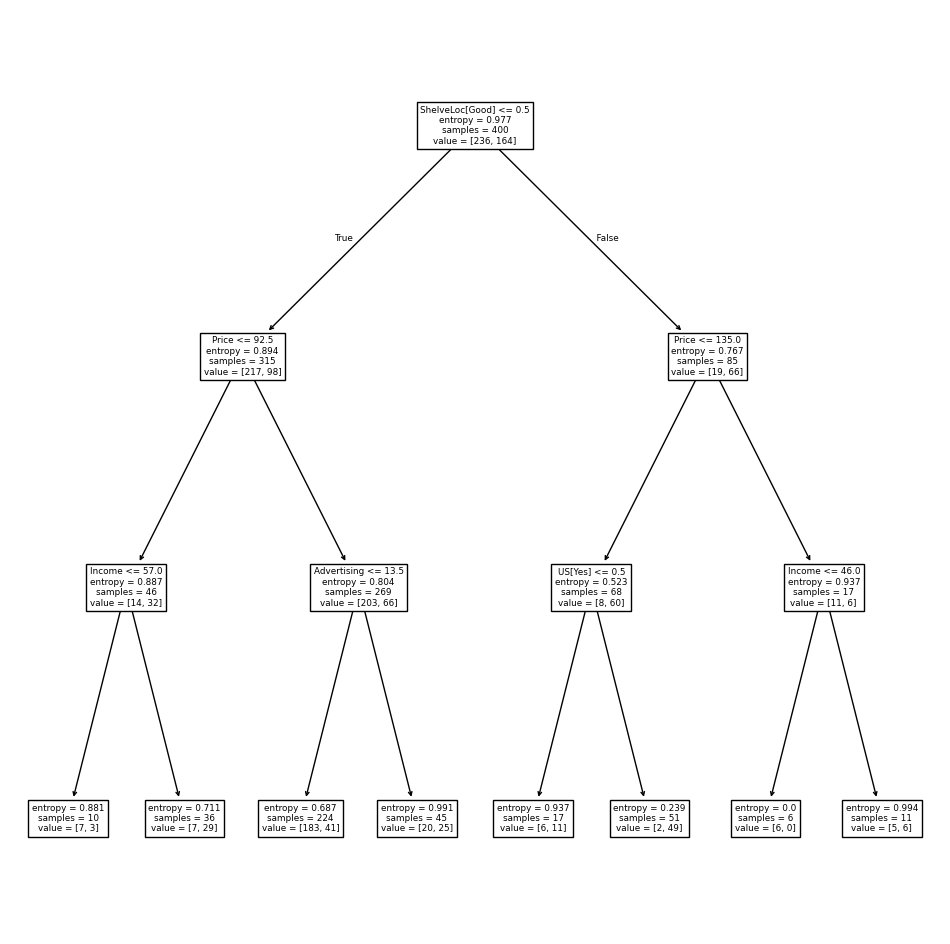

In [8]:
_, ax = plt.subplots(figsize=(12, 12))
plot_tree(clf, feature_names=feature_names, ax=ax);

In [9]:
print(export_text(clf, feature_names=feature_names, show_weights=True))

|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: No
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: Yes
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: No
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: Yes
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 135.00
|   |   |--- US[Yes] <= 0.50
|   |   |   |--- weights: [6.00, 11.00] class: Yes
|   |   |--- US[Yes] >  0.50
|   |   |   |--- weights: [2.00, 49.00] class: Yes
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: No
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: Yes



### Cross-validation

In [10]:
val = skm.ShuffleSplit(n_splits=1, test_size=200, random_state=0)
results = skm.cross_validate(clf, D, High, cv=val, return_train_score=True)
results['test_score'], results['train_score']

(array([0.685]), array([0.77]))

### Pruning

In [11]:
X_train, X_test, High_train, High_test = skm.train_test_split(X, High, test_size=.5, random_state=0)
X_train.shape, X_test.shape, High_train.shape, High_test.shape

((200, 11), (200, 11), (200,), (200,))

In [12]:
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, High_train)

,criterion,'entropy'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [13]:
accuracy_score(High_test, clf.predict(X_test))

0.735

In [14]:
ccp_path = clf.cost_complexity_pruning_path(X_train, High_train)
kfold = skm.KFold(10, random_state=1, shuffle=True)

In [15]:
param_grid = {'ccp_alpha': ccp_path.ccp_alphas}
grid = skm.GridSearchCV(
    clf,
    param_grid=param_grid,
    refit=True,
    cv=kfold,
    scoring='accuracy'
)
grid.fit(X_train, High_train)
grid.best_score_, grid.best_params_

(0.685, {'ccp_alpha': 0.018048202372184057})

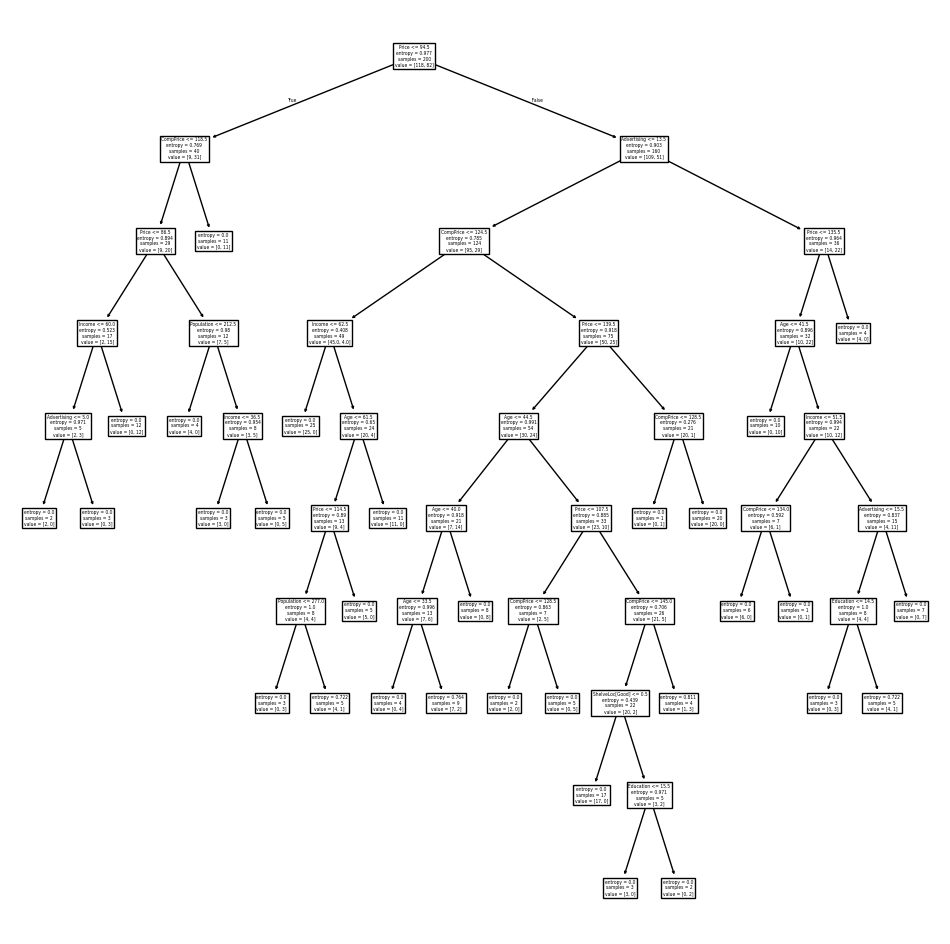

In [16]:
_, ax = plt.subplots(figsize=(12, 12))
best_ = grid.best_estimator_
plot_tree(best_, feature_names=feature_names, ax=ax);

In [17]:
best_.tree_.n_leaves

30

In [18]:
accuracy_score(High_test, best_.predict(X_test))

0.72

In [19]:
confusion_table(best_.predict(X_test), High_test)

Truth,No,Yes
Predicted,,
No,94,32
Yes,24,50


## Regression trees

### Boston data

In [20]:
Boston = load_data('Boston')
Boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


In [21]:
ms = MS(Boston.columns.drop('medv'), intercept=False)
D = ms.fit_transform(Boston)
feature_names = D.columns.tolist()
X = np.asarray(D)
X.shape

(506, 12)

### Train-test split

In [22]:
(X_train, X_test, y_train, y_test) = skm.train_test_split(X, Boston['medv'], test_size=.3, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((354, 12), (152, 12), (354,), (152,))

In [23]:
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


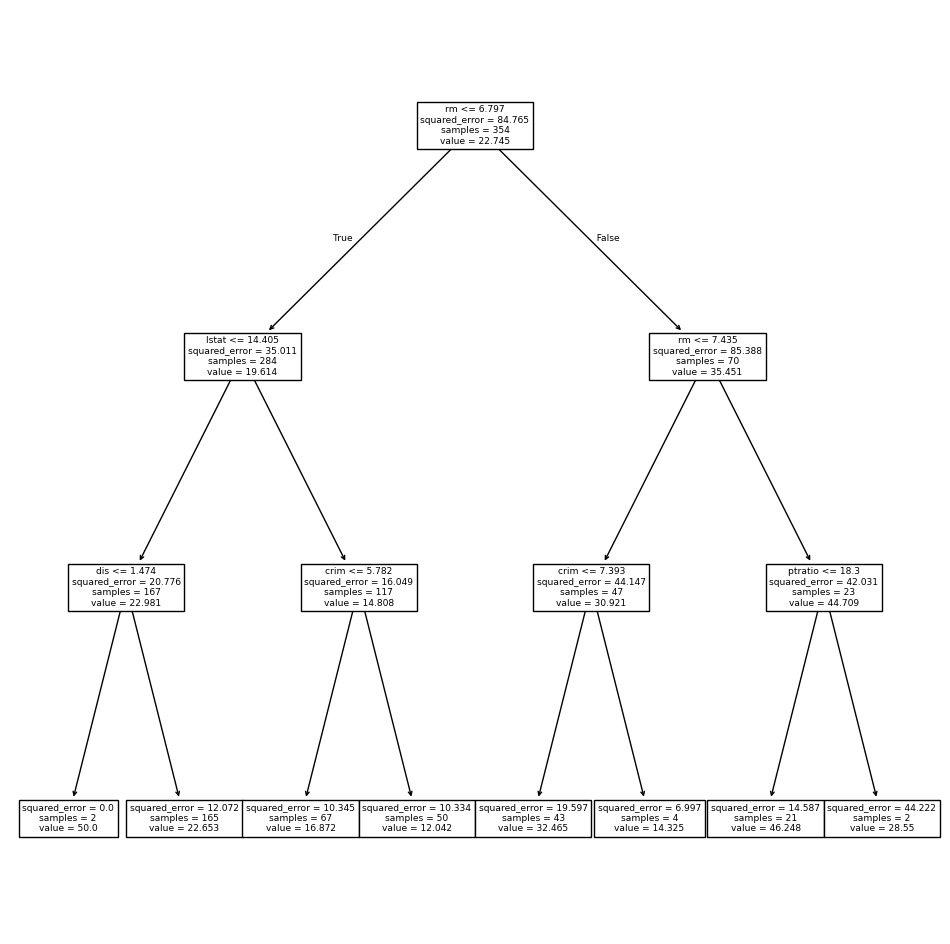

In [24]:
_, ax = plt.subplots(figsize=(12, 12))
plot_tree(reg, feature_names=feature_names, ax=ax);

### Cross-validation

In [25]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5, shuffle=True, random_state=10)

param_grid = {'ccp_alpha': ccp_path.ccp_alphas}
grid = skm.GridSearchCV(
    reg, param_grid=param_grid, 
    refit=True, cv=kfold, 
    scoring='neg_mean_squared_error',
    return_train_score=True,
)

grid.fit(X_train, y_train)

,estimator,DecisionTreeR...r(max_depth=3)
,param_grid,{'ccp_alpha': array([ 0. ... 39.79182618])}
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,criterion,'squared_error'


Training error.

In [26]:
-grid.best_score_

22.39772966044506

Test error.

In [27]:
best_ = grid.best_estimator_
mean_squared_error(y_test, best_.predict(X_test))

28.069857549754033

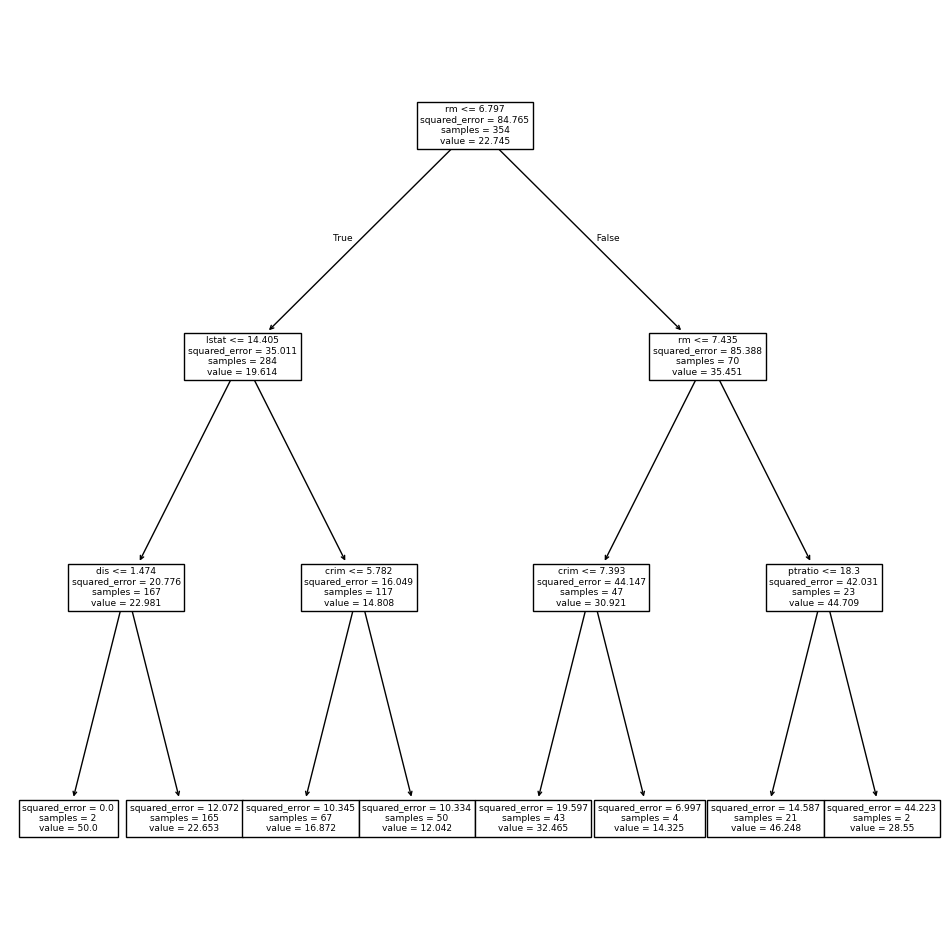

In [28]:
_, ax = plt.subplots(figsize=(12, 12))
plot_tree(grid.best_estimator_, feature_names=feature_names, ax=ax);

## Bagging and random forest

### Bagging

We set `max_features` to `12`, which means it will consider all features at every split.

In [29]:
bag_boston = RF(max_features=X_train.shape[1], random_state=0)
bag_boston.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,12
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [30]:
y_hat_bag = bag_boston.predict(X_test)
mean_squared_error(y_test, y_hat_bag)

14.684333796052627

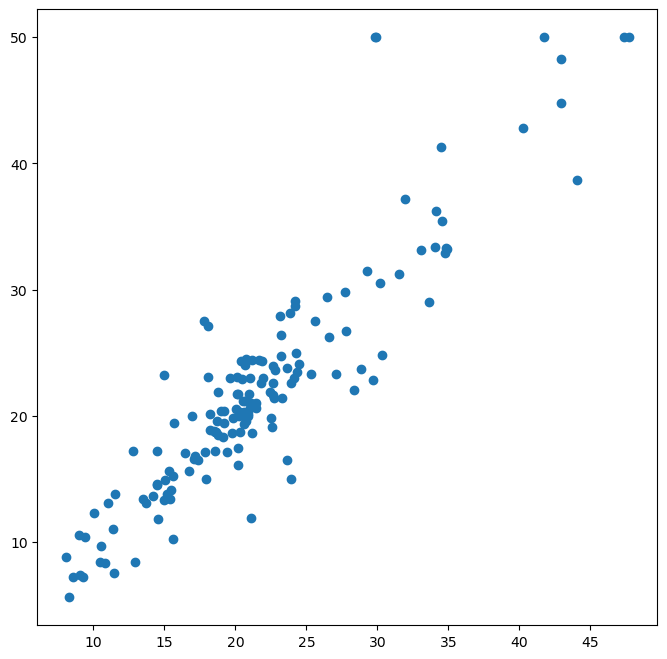

In [31]:
_, ax = plt.subplots(figsize=(8, 8))
ax.scatter(y_hat_bag, y_test);

Increasing the number of strees to `500`.

In [32]:
bag_boston = RF(
    max_features=X_train.shape[1],
    n_estimators=500,
    random_state=0
).fit(X_train, y_train)

y_hat_bag = bag_boston.predict(X_test)
mean_squared_error(y_test, y_hat_bag)

14.565312103157904

### Random forest

The default parameter for `max_features` is `sqrt`, here we use 6.

In [33]:
rf_boston = RF(
    max_features=6,
    n_estimators=500,
    random_state=0
).fit(X_train, y_train)

y_hat_rf = rf_boston.predict(X_test)
mean_squared_error(y_test, y_hat_rf)

18.75262661473685

It seems random forest did worst than bagging.

### Feature importance

In [34]:
feature_imp = pd.DataFrame(
    {'importance': rf_boston.feature_importances_,}, 
    index=feature_names,
).sort_values(by='importance')
feature_imp 

,importance
chas,0.002760
zn,0.003326
rad,0.005593
tax,0.022616
age,0.023721
nox,0.034668
dis,0.042371
indus,0.052762
crim,0.052865
ptratio,0.056495


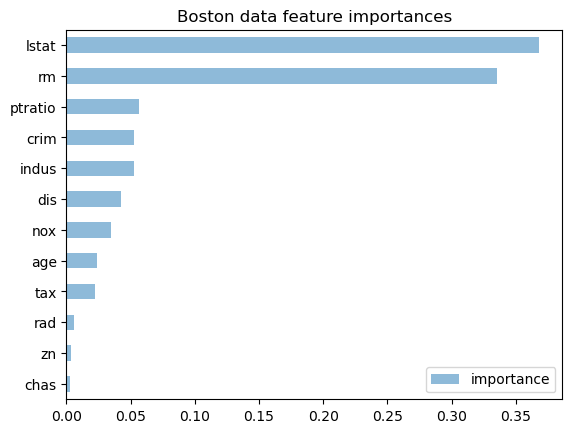

In [35]:
_, ax = plt.subplots()

feature_imp.plot(kind='barh', ax=ax, alpha=.5)

ax.set_title('Boston data feature importances')
ax.legend(loc='lower right');

## Boosting

In [36]:
boost_boston = GBR(
    n_estimators=5000,
    learning_rate=0.001,
    random_state=0
)
boost_boston.fit(X_train, y_train)

,loss,'squared_error'
,learning_rate,0.001
,n_estimators,5000
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


### Train/test error rate

In [37]:
test_error = np.zeros_like(boost_boston.train_score_)
for idx, y_ in enumerate(boost_boston.staged_predict(X_test)):
   test_error[idx] = mean_squared_error(y_test, y_)

test_error.shape

(5000,)

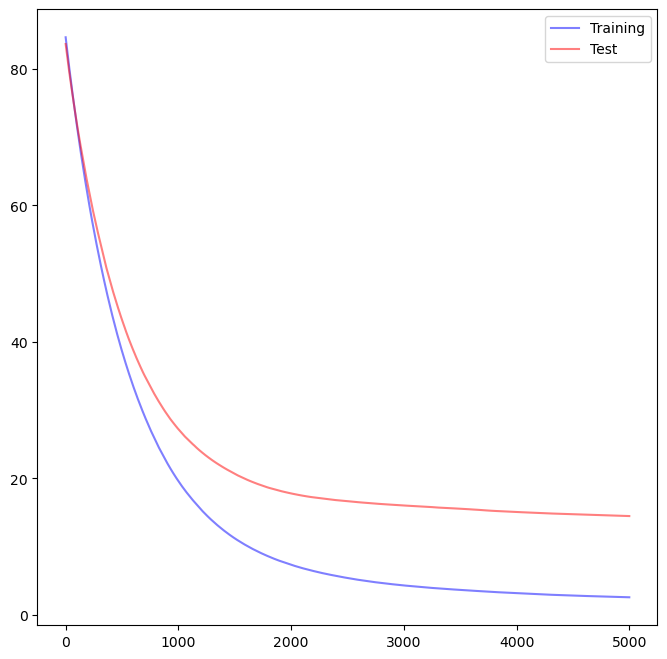

In [38]:
plot_idx = np.arange(boost_boston.train_score_.shape[0])
_, ax = plt.subplots(figsize=(8,8))
ax.plot(
    plot_idx,
    boost_boston.train_score_,
    'b',
    label='Training',
    alpha=.5
)
ax.plot(
    plot_idx,
    test_error,
    'r',
    label='Test',
    alpha=.5
)
ax.legend();

In [39]:
y_hat_boost = boost_boston.predict(X_test)
mean_squared_error(y_test, y_hat_boost)

14.478980532887332

Using the default `learning_rate=.1`.

In [40]:
boost_boston = GBR(n_estimators=5000, random_state=0)
boost_boston.fit(X_train, y_train)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,5000
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [41]:
y_hat_boost = boost_boston.predict(X_test);
mean_squared_error(y_test, y_hat_boost)

12.741967307155218

Using the default `learning_rate` seem to provide an improvement to the earlier model.

## BART

In [42]:
bart_boston = BART(random_state=0, burnin=5, ndraw=15)
bart_boston.fit(X_train, y_train)

,num_trees,200
,num_particles,10
,max_stages,5000
,split_prob,<function BAR...t 0x1633c9f80>
,min_depth,0
,std_scale,2
,split_prior,None
,ndraw,15
,burnin,5
,sigma_prior,"(5, ...)"
,num_quantile,50


In [43]:
yhat_test = bart_boston.predict(X_test.astype(np.float64))
mean_squared_error(y_test, yhat_test)

21.00800852161198

In [44]:
var_inclusion = pd.Series(
    bart_boston.variable_inclusion_.mean(0), 
    index=D.columns
).sort_values(ascending=False)
var_inclusion

lstat      31.000000
rm         29.800000
zn         27.866667
crim       26.933333
nox        26.600000
indus      26.466667
dis        26.466667
ptratio    24.266667
tax        24.133333
rad        23.666667
age        22.733333
chas       22.466667
dtype: float64

Text(0.5, 1.0, 'Variable inclusion')

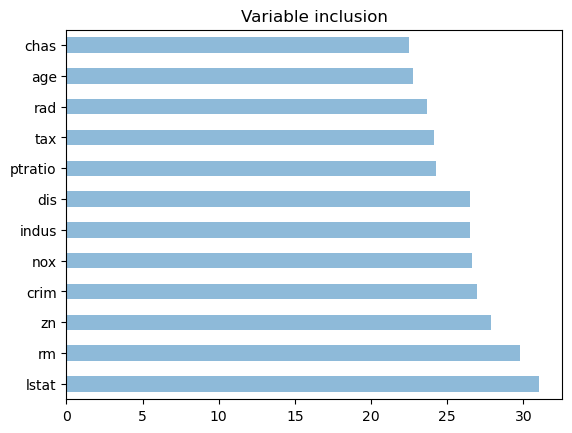

In [45]:
_, ax = plt.subplots()

var_inclusion.plot(kind='barh', ax=ax, alpha=.5)
ax.set_title('Variable inclusion')